# Correlation of Oceanic Nino Index and Fire Weather Index With Emphasis on The Amazon Rainforest Region

Because the raw data files contain a lot of unnecessary data, making them large files, and because the initial data processing can take some time I included a NetCDF with the already processed data. All of the code I used is included, but I do not recommend running each section. I recommend beginning at the Establish Correlation section but if you would like to run it all I will include a text file with the file paths to bulk download all of the data.

### Import modules and load data

In [2]:
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
#This creates the data paths text file that was submitted
#using the the wget command (wget -i nc_file_paths.txt) all the data can be downloaded

start_str = 'https://portal.nccs.nasa.gov/datashare/GlobalFWI/v2.0/fwiCalcs.MERRA2/Default/MERRA2/'
mid_str = '/FWI.MERRA2.Monthly.Default.'
months = [31,28,31,30,31,30,31,31,30,31,30,31]
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
day = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
paths_list = []
temp_str = 'temp'
for i in range(40):
    for j in range(12):
            temp_str = start_str + str(1981+i) + mid_str + str(1981+i) +month[j]  + '.nc'
            paths_list.append(temp_str)
#print(paths_list)   
with open('nc_file_paths.txt', 'w') as paths:
    for listitem in paths_list:
        paths.write('%s\n' % listitem)

In [86]:
#Load data from 476 .nc files 

dt_parse = '%Y%m'
def get_date_num(stri):
    date1 = datetime.datetime.strptime(stri, dt_parse)
    return(date.toordinal(date1.date()))
list_of_paths = glob.glob('C:/Users/Patrick/Desktop/175_final/global_fwi_analysis/FWI_nc\'s/*.nc', recursive=True)
nc_list = []
nc_date_list = []
nc_date_key = []
nc_date_int = []
for path in list_of_paths:
    nc_list.append(nc.Dataset(path))
    nc_date_list.append(get_date_num(path[-9:-3]))
    nc_date_key.append((path[-9:-3]))
sample = nc_list[0]

### Process data

In [81]:
normed_date = np.round(np.array(nc_date_list) - np.mean(np.array(nc_date_list)))
print(len(normed_date))

476


In [77]:
#Compile data into one 3D array

fwi = []
for i in nc_list:
    fwi.append(i['MERRA2_FWI'][0])
fwi_array = np.dstack(fwi)

<ipython-input-77-9ad865a6f5eb>:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fwi.append(i['MERRA2_FWI'][0])
<ipython-input-77-9ad865a6f5eb>:5: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  fwi.append(i['MERRA2_FWI'][0])


In [ ]:
#Computes the Yearly Averages

years = list(range(1982, 2020))
for i in range(len(years)):
    years[i] = str(years[i])
#print(years)
yearly_list = []

for year in years:
    temp_array_list = []
    for i in range(476):
        if(nc_date_key[i][0:4] == year):
            temp_array_list.append(fwi_array[:,:,i])
    #print(len(temp_array_list))
    avg_array = np.empty((267,576))
    avg_array[:] = np.nan
    for j in range(267):
        for k in range(576):
            point_list = []
            for q in range(len(temp_array_list)):
                point_list.append(temp_array_list[q][j,k])
            avg_array[j,k] = np.nanmean(np.array(point_list))
    yearly_list.append(avg_array)
    print(str(100*(int(year) - int(years[0]))/ (int(years[-1])-int(years[0]))) + '%')

In [79]:
year_from_start = np.array(list(range(34)))
yearly_array = np.dstack(yearly_list)
years_int = np.empty([38])
for i in range(len(years)):
    years_int[i] = int(years[i])
normed_year = np.array(years_int)-np.nanmean(np.array(years_int))

In [96]:
#Generates linear trend and removes the trend from the FWI monthly array

t_trend_slope = np.empty([267, 576])
t_trend_intercept = np.empty([267, 576])
t_trend_rvalue = np.empty([267, 576])
t_trend_pvalue = np.empty([267, 576])
t_trend_stderr = np.empty([267, 576])

t_fwi_point = np.empty([476])
for i in range(267):
    for j in range(576):
        t_fwi_point = fwi_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(t_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(t_fwi_point) & ~np.isnan(normed_date)
            t_trend_slope[i,j], t_trend_intercept[i,j], t_trend_rvalue[i,j], t_trend_pvalue[i,j], t_trend_stderr[i,j] = stats.linregress(normed_date[mask], t_fwi_point[mask])
        else:
            t_trend_slope[i,j] = np.float('NaN')
            t_trend_pvalue[i,j] = np.float('NaN')
            
fwi_detrend = np.empty((267, 576, 476))
for i in range(476):
    fwi_detrend[:,:,i] = fwi_array[:,:,i] - normed_date[i]*t_trend_slope[:,:]        

<ipython-input-96-58b8d00635f3>:14: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(t_fwi_point)))):
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [ ]:
#Generates linear trend and removes the trend from the FWI yearly array

ty_trend_slope = np.empty([267, 576])
ty_trend_intercept = np.empty([267, 576])
ty_trend_rvalue = np.empty([267, 576])
ty_trend_pvalue = np.empty([267, 576])
ty_trend_stderr = np.empty([267, 576])

ty_fwi_point = np.empty([38])
for i in range(267):
    for j in range(576):
        ty_fwi_point = yearly_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(ty_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(ty_fwi_point) & ~np.isnan(normed_year)
            ty_trend_slope[i,j], ty_trend_intercept[i,j], ty_trend_rvalue[i,j], ty_trend_pvalue[i,j], ty_trend_stderr[i,j] = stats.linregress(normed_year[mask], ty_fwi_point[mask])
        else:
            ty_trend_slope[i,j] = np.float('NaN')
            ty_trend_pvalue[i,j] = np.float('NaN')
            
fwi_y_detrend = np.empty((267, 576, 38))
for i in range(38):
    fwi_y_detrend[:,:,i] = yearly_array[:,:,i] - normed_year[i]*ty_trend_slope[:,:]        

In [ ]:
#compiles the monthly data into three month averages to match the ONI data

def three_month_avg(dataset, index):
    temp_array = np.empty([267,576])
    for i in range(267):
        for j in range(576):
            temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))
    return(temp_array)
three_month_list = []
for i in range(476):
    three_month_list.append(three_month_avg(fwi_detrend, i))
    print(str((i/464)*100)+'%')
    
three_month_avg = np.dstack(three_month_list)    

### Establish Correlation

In [ ]:
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date
from matplotlib.colors import LinearSegmentedColormap

In [102]:
#Loads processed data from NetCDF file. This is where you start if you are using the file I provided

data = nc.Dataset('aggregate_data_10.nc')
print(data)
three_month_avg = data['mFWI']
fwi_y_detrend = data['yFWI']
t_trend_slope = data['mSlope'][:]
t_trend_pvalue = data['mPval'][:]


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Aggregated FWI Data
    subtitle: Organized into a running three month average timeseries and a yearly average timeseries. Both have linear trend removed.
    dimensions(sizes): lat(267), lon(576), month(474), year(38)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int32 month(month), int32 year(year), float32 yFWI(lat,lon,year), float32 mFWI(lat,lon,month), float32 mSlope(lat,lon), float32 mPval(lat,lon)
    groups: 


<ipython-input-102-b289219f8be6>:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(data)


In [43]:
#Removes the seasonal cycle from the detrend monthly data

temp_count = 0
monthly_list = [[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range(474):
    monthly_list[temp_count].append(three_month_avg[:,:,i])
    temp_count += 1
    if(temp_count == 12):
        temp_count = 0
        
avg_list = []
for i in range(12):
    month_avg_array = np.empty([267,576])
    for k in range(267):
            for l in range(576):
                temp_list = []
                for j in range(len(monthly_list[i])):
                    temp_list.append(monthly_list[i][j][k,l])
                month_avg_array[k,l] = np.nanmean(np.array(temp_list))
    avg_list.append(month_avg_array)    
    
fwi_m_dets = np.empty([267, 576, 474])
temp_count = 0
for i in range(474):
    fwi_m_dets[:,:,i] = three_month_avg[:,:,i]-avg_list[temp_count]
    temp_count += 1
    if(temp_count == 12):
        temp_count = 0    

In [ ]:
#Load ONI data

oni_raw = np.genfromtxt('oni.csv', delimiter=',')
#print(np.shape(oni_raw))
oni_list = []
for i in range(40):
    for j in range(12):
        oni_list.append(oni_raw[i,j])
ONI = np.array(oni_list[:476])
#print(len(ONI))

yONI = np.genfromtxt('oni_yearly.csv', delimiter=',')
#print(np.shape(oni_raw))

print(len(yONI))
print(len(ONI))

In [67]:
#Correlate the three month average data with the ONI data

m_coeff = np.empty([267, 576])

oni_fwi_point = np.empty([474])
for i in range(267):
    for j in range(576):
        oni_fwi_point = fwi_m_dets[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point[:]) & ~np.isnan(ONI[1:-1])
            m_coeff[i,j] = (np.corrcoef(ONI[1:-1][mask], oni_fwi_point[:][mask]))[0,1]
        else:
            m_coeff[i,j] = np.float('NaN')

<ipython-input-67-cd303b285824>:10: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):


In [92]:
#Correlate yearly data with ONI yearly averages

t_coeff = np.empty([267, 576])

oni_fwi_point2 = np.empty([38])
for i in range(267):
    for j in range(576):
        oni_fwi_point2 = fwi_y_detrend[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point2)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point2) & ~np.isnan(yONI)
            t_coeff[i,j] = (np.corrcoef(yONI[mask], oni_fwi_point2[mask]))[0,1]
        else:
            t_coeff[i,j] = np.float('NaN')

<ipython-input-92-a10741a52aa2>:10: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point2)))):
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\Patrick\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


### Create Visualizations

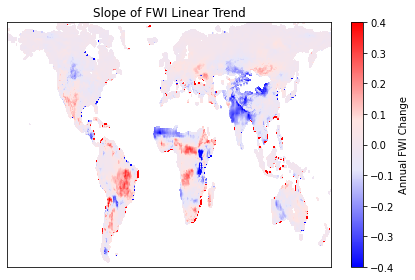

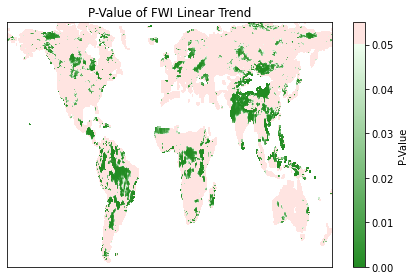

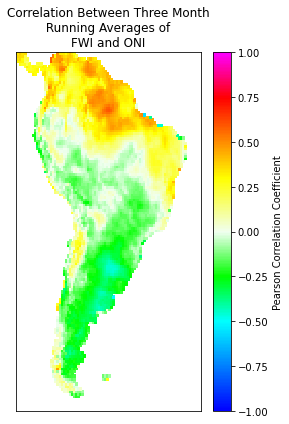

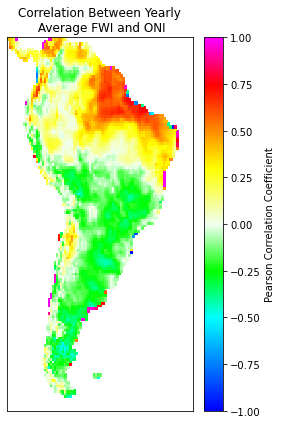

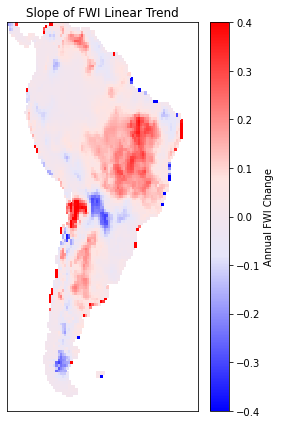

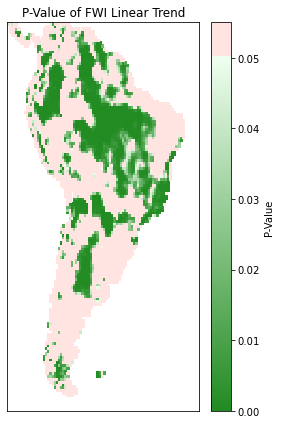

In [105]:
#Generates and Saves figures

plt.figure(1)
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('global_FWI_linear_trend_slope.png')

plt.figure(2)
colors2 = ['forestgreen', 'honeydew','mistyrose', 'mistyrose']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue, cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('global_FWI_linear_trend_pval')

plt.figure(3, figsize = ([4,6]))
colors3 = ['blue','cyan', 'lime','honeydew','yellow','red','magenta']
nodes3 = [0,.25,.375,.5,.65,.875,1]
cmap3 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes3,colors3)))
plt.pcolormesh(m_coeff[0:140,150:240], vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between Three Month\n Running Averages of \nFWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('three_month_correlation.png')

plt.figure(4, figsize = ([4,6]))
plt.pcolormesh(t_coeff[0:140,150:240], vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between Yearly\n Average FWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('yearly_correlation.png')

plt.figure(5, figsize = ([4,6]))
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope[0:140,150:240]*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('sa_FWI_linear_trend_slope.png')

plt.figure(6, figsize = ([4,6]))
colors2 = ['forestgreen', 'honeydew','mistyrose', 'mistyrose']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue[0:140,150:240], cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.savefig('sa_FWI_linear_trend_pval.png')

### Save Processed Data

In [87]:
nc_date_int_key = []
for i in range(len(nc_date_key)):
    nc_date_int_key.append(int(nc_date_key[i]))

In [99]:
#Produces the NetCDF file I provided. Do not run this code block
ncfile = Dataset('aggregate_data_10.nc', mode = 'w', format = 'NETCDF4_CLASSIC')
lat_dim = ncfile.createDimension('lat', 267)
lon_dim = ncfile.createDimension('lon', 576)
month_dim = ncfile.createDimension('month', 474)
year_dim = ncfile.createDimension('year', 38)
ncfile.title = 'Aggregated FWI Data'
ncfile.subtitle = 'Organized into a running three month average timeseries and a yearly average timeseries. Both have linear trend removed.'
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon',np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
month = ncfile.createVariable('month', np.int32, ('month',))
month.units = 'yyyymm'
month.long_name = 'Month and Year of Monthly Data'
year = ncfile.createVariable('year', np.int32, ('year',))
month.units = 'yyyy'
yFWI = ncfile.createVariable('yFWI', np.float32, ('lat', 'lon', 'year'))
yFWI.units = 'Unitless'
yFWI.long_name = 'Annual average global fire weather index'
mFWI = ncfile.createVariable('mFWI', np.float32, ('lat', 'lon', 'month'))
mFWI.units = 'Unitless'
mFWI.long_name = '3 month running average global fire weather index'
mSlope = ncfile.createVariable('mSlope', np.float32, ('lat', 'lon'))
mSlope.units = 'FIW per day'
mSlope.long_name = 'Slope of linear trend for monthly data'
mPval = ncfile.createVariable('mPval', np.float32, ('lat', 'lon'))
mPval.long_name = 'Pvalue of linear trend for monthly data'
yFWI[:,:,:] = yearly_array[:,:,:]
mFWI[:,:,:] = three_month_avg[:,:,:]
lat[:] = sample['lat'][:]
lon[:] = sample['lon'][:]
month[:] = nc_date_int_key[:-2]
year[:] = years_int
mSlope[:,:] = t_trend_slope[:,:]
mPval[:,:] = t_trend_pvalue[:,:]
ncfile.close()